<div style="margin: 2em 5em 0 0;">
    
<p>
   <span style="margin-left: 17%; vertical-align: text-bottom;">&nbsp;&bullet;&nbsp; Business Analytics &nbsp;&bullet;&nbsp; Machine Learning - FMsBA3 &nbsp;&bullet;&nbsp; Hult International Business School</span>
</p>
<br>
<hr style="height: 1px; margin-top: -.2em">


<center>
   <br>
   <span style="font-size: 155%; font-weight: bold; font-family: "Times New Roman", Times, serif;">
      Classification Model Development | Apprentice Chef Case
   </span>
   <br>
   <br>
   <div style="font-size: 107%; margin-top: .3em">
      <b>Instructor: Prof. Chase Kusterer</b>
      <br style="margin-bottom: .5em">
      <b>Ohyoung Kim </b><br>
      <br>
   </div>
</center>


# Part I: Preparation and Exploration

### a) Importing libraries and Loading the Dataset

In [1]:
## Basic packages ##
import random            as rand                     # random number gen
import numpy as np                                   # mathematical essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data visualization
import pandas            as pd                       # data science essentials

## Data preprocessing package ##
from sklearn.preprocessing import StandardScaler     # standard scaler
import gender_guesser.detector as gender # guess gender based on (given) name

## Data split package ##
from sklearn.model_selection import train_test_split # train-test split

## Classification Model packages ##
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

# CART model packages
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO                             # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects

## Model test hypothesis packages ##
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score

## Optimization packages ##
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer                    # customizable scorer

In [2]:
# Setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Specifying file name
file = './Apprentice_Chef_Dataset.xlsx'

# Reading the file into Python
chef_df = pd.read_excel(io = file)

# Checking the first 5 rows of the dataset
chef_df.head(n = 5)

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205


#### a.1 Creating and Lodaing some useful User-Defined Functions

In [3]:
#########################
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

In [4]:
########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

### b) Loading the Chef data dictionary

In [6]:
# Pulling up data dictionary
chef_df_description = pd.read_excel('./Apprentice_Chef_Data_Dictionary.xlsx')


# Displaying the data dictionary
chef_df_description

,Feature,Data Type,Description
0,REVENUE,Float,Total revenue generated from each customer. No...
1,CROSS_SELL_SUCCESS,Integer,"Success of the cross-sell promotion (1 = yes, ..."
2,NAME,string,Full name of customer
3,EMAIL,string,Email of customer
4,FIRST_NAME,string,First name of customer
5,FAMILY_NAME,string,Last name of customer
6,TOTAL_MEALS_ORDERED,Integer,Total number of meals ordered by each customer...
7,UNIQUE_MEALS_PURCH,Integer,Number of unique meal sets ordered by each cus...
8,CONTACTS_W_CUSTOMER_SERVICE,Integer,Number of times each customer made contact wit...
9,PRODUCT_CATEGORIES_VIEWED,Integer,"Total number of meal categories viewed (vegan,..."


### c) Checking dataset anomalies

#### c.1 Exploring the dataset for missing values

In [7]:
# Checking for missing values
#chef_df.isnull().sum()

#### c.2 Developing a strategy for specific variables: missing values or object type

In [8]:
# Checking information about each variable
#chef_df.info()

In [9]:
## Variables that include missing values or are object data type ##

# NAME        - feature out, drop original
# EMAIL       - one-hot encode, drop original
# FIRST_NAME  - one-hot encode, drop original
# FAMILY_NAME - drop

#### c.3 Dropping Feature

In [10]:
# Dropping an unnecessary feature
chef_df = chef_df.drop(labels = 'FAMILY_NAME', axis   = 1)

# Checking results
#chef_df.columns

### d) Preprocessing the Data

#### d.1 Developing a number of names feature with NAME column

In [11]:
# Calling text_split_feature function
text_split_feature(col = 'NAME', df  = chef_df)

# Checking results
chef_df['number_of_names'].value_counts().sort_index()

1     591
2    1201
3      98
4       9
5      35
6      12
Name: number_of_names, dtype: int64

In [12]:
# Dropping an unnecessary feature
chef_df.drop(columns = 'NAME', inplace = True)

# Checking results
#chef_df.columns

#### d.2 Conducting one-hot encoding on columns

###### d.2.1 Column: EMAIL

In [13]:
# Splitting emails and concatenating with original DataFrame
chef_df['email_domain'] = chef_df.EMAIL.str.split('@').str[-1]

# Aggregating the email domains into domain groups
# Creating 3 types of email domain
professional_email_domains = ['@mmm.com', '@amex.com', '@apple.com',
                              '@boeing.com', '@caterpillar.com', '@chevron.com',
                              '@cisco.com', '@cocacola.com', '@disney.com', 
                              '@dupont.com', '@exxon.com', '@ge.org', '@goldmansacs.com',
                              '@homedepot.com', '@ibm.com', '@intel.com', '@jnj.com',
                              '@jpmorgan.com', '@mcdonalds.com', '@merck.com', 
                              '@microsoft.com', '@nike.com', '@pfizer.com', 
                              '@pg.com', '@travelers.com', '@unitedtech.com',
                              '@unitedhealth.com', '@verizon.com', '@visa.com', 
                              '@walmart.com']
personal_email_domains = ['@gmail.com', '@yahoo.com', '@protonmail.com']
junk_email_domains = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', 
                      '@msn.com', '@passport.com']

# Creating a placeholder list
placeholder_lst = []

# Looping to group observations by domain types
for domain in chef_df['email_domain']:
        if '@' + domain in professional_email_domains:
            placeholder_lst.append('email_professional')
            
        elif '@' + domain in personal_email_domains:
            placeholder_lst.append('email_personal')
            
        elif '@' + domain in junk_email_domains:
            placeholder_lst.append('email_junk')
            
        else:
            placeholder_lst.append('unknown')

# Concatenating with original DataFrame
chef_df['domain_group'] = pd.Series(placeholder_lst)

# Checking results
chef_df['domain_group'].value_counts()

email_personal        861
email_professional    696
email_junk            389
Name: domain_group, dtype: int64

In [14]:
# One hot encoding categorical variables
one_hot_domain = pd.get_dummies(chef_df['domain_group'])

# Dropping categorical variables after they've been encoded
chef_df = chef_df.drop('domain_group', axis = 1)

# Joining codings together
chef_df = chef_df.join([one_hot_domain])

In [15]:
# Dropping unnecessary features
chef_df.drop(columns = ['EMAIL', 'email_domain'], inplace = True)

# Checking results
#chef_df.columns

###### d.2.2 Column: FIRST_NAME

In [16]:
"""
# Guessing gender based on (given) name
# Creating a placeholder list
placeholder_lst = []

# Looping to guess gender
for name in chef_df.loc[ : , 'FIRST_NAME' ]:
    guess = gender.Detector().get_gender(name)
    print(guess)
    placeholder_lst.append(guess)


# Converting list into a series
chef_df['gender_guess'] = pd.Series(placeholder_lst)
"""

"\n# Guessing gender based on (given) name\n# Creating a placeholder list\nplaceholder_lst = []\n\n# Looping to guess gender\nfor name in chef_df.loc[ : , 'FIRST_NAME' ]:\n    guess = gender.Detector().get_gender(name)\n    print(guess)\n    placeholder_lst.append(guess)\n\n\n# Converting list into a series\nchef_df['gender_guess'] = pd.Series(placeholder_lst)\n"

In [17]:
# It takes a long time to execute the above code
# Replace with the following two steps to quickly identify the results.

# Step 1: Checking results
#placeholder_lst[0:1000]
#placeholder_lst[1000:]

# Step 2: Saving the contents of placeholder_lst
gender_lst = ['unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'mostly_male',
 'female',
 'unknown',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'female',
 'female',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'female',
 'unknown',
 'andy',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'mostly_male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'mostly_male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'mostly_male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'unknown',
 'andy',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'andy',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'female',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'female',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'mostly_female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'female',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'mostly_female',
 'unknown',
 'male',
 'unknown',
 'female',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'female',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'male',
 'male',
 'mostly_male',
 'male',
 'male',
 'male',
 'male',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'andy',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'female',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'female',
 'male',
 'male',
 'female',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown', 
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'andy',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'andy',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'male',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'male',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'mostly_female',
 'male',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'female',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'mostly_male',
 'mostly_male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'female',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'mostly_male',
 'unknown',
 'unknown',
 'male',
 'andy',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'female',
 'male',
 'female',
 'mostly_female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'mostly_female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'female',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'male',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'mostly_female',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'mostly_female',
 'female',
 'female',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'andy',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'male',
 'male',
 'unknown',
 'male',
 'unknown',
 'mostly_male',
 'female',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'mostly_male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'mostly_female',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'andy',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'mostly_male',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'male',
 'male',
 'male',
 'male',
 'andy',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'female',
 'female',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'male',
 'unknown',
 'unknown',
 'female',
 'unknown',
 'unknown']

In [18]:
# Creating 3 types of gender
male = ['male', 'mostly_male']
female = ['female', 'mostly_female']
unknown = ['unknown', 'andy']

# Creating a placeholder list
adjusted_gender_lst = []

# Looping to group observations by domain types
for gender in gender_lst:
        if gender in male:
            adjusted_gender_lst.append('male')
            
        elif gender in female:
            adjusted_gender_lst.append('female')
            
        elif gender in unknown:
            adjusted_gender_lst.append('gender_unknown')
            

# Concatenating with original DataFrame
chef_df['gender_test'] = pd.Series(adjusted_gender_lst)

# Checking results
chef_df['gender_test'].value_counts()

gender_unknown    1395
male               405
female             146
Name: gender_test, dtype: int64

In [19]:
# One hot encoding categorical variables
one_hot_gender = pd.get_dummies(chef_df['gender_test'])

# Dropping categorical variables after they've been encoded
chef_df = chef_df.drop('gender_test', axis = 1)

# Joining codings together
chef_df = chef_df.join([one_hot_gender])

In [20]:
# Dropping an unnecessary feature
chef_df.drop(columns = 'FIRST_NAME', inplace = True)

# Checking results
chef_df.columns

Index(['REVENUE', 'CROSS_SELL_SUCCESS', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED', 'number_of_names', 'email_junk', 'email_personal', 'email_professional', 'female', 'gender_unknown', 'male'], dtype='object')

# Part II: Logistic Regression

### a) Correlation Analysis

In [21]:
# Developing a correlation matrix
df_corr = chef_df.corr(method = "pearson").round(decimals = 2)

# Filtering the results to only show correlations with CROSS_SELL_SUCCESS
df_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS             1.00
email_professional             0.19
number_of_names                0.16
CANCELLATIONS_BEFORE_NOON      0.16
male                           0.12
MOBILE_NUMBER                  0.10
TASTES_AND_PREFERENCES         0.08
REFRIGERATED_LOCKER            0.07
CONTACTS_W_CUSTOMER_SERVICE    0.04
PC_LOGINS                      0.04
MASTER_CLASSES_ATTENDED        0.04
PACKAGE_LOCKER                 0.04
email_personal                 0.04
AVG_PREP_VID_TIME              0.03
MEDIAN_MEAL_RATING             0.03
LARGEST_ORDER_SIZE             0.02
EARLY_DELIVERIES               0.02
AVG_TIME_PER_SITE_VISIT        0.01
TOTAL_MEALS_ORDERED            0.01
LATE_DELIVERIES                0.01
TOTAL_PHOTOS_VIEWED            0.01
PRODUCT_CATEGORIES_VIEWED      0.00
UNIQUE_MEALS_PURCH             0.00
REVENUE                        0.00
WEEKLY_PLAN                   -0.01
AVG_CLICKS_PER_VISIT          -0.04
MOBILE_LOGINS                 -0.05
CANCELLATIONS_AFTER_NOON    

### b) Preparing Explanatory and Response Data

In [22]:
# Declaring explanatory variables
chef_df_data = chef_df.drop('CROSS_SELL_SUCCESS' , axis = 1)


# Declaring response variable
chef_df_response = chef_df.loc[ :  ,'CROSS_SELL_SUCCESS']

### c) Preparing train-test split for statsmodels

In [23]:
# Train-Test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            chef_df_data,
            chef_df_response,
            test_size    = 0.25,
            random_state = 219,
            stratify     = chef_df_response)


# Merging training data for statsmodels
chef_df_train = pd.concat([x_train, y_train], axis = 1)

### d)  Building a logistic regression model in statsmodels using all of the explanatory variables

In [24]:
#for val in chef_df_data:
#    print(f" {val} + ")

In [25]:
# Instantiating a logistic regression model object
logistic_full = smf.logit(formula = """  CROSS_SELL_SUCCESS  ~  
                                         REVENUE +
                                         TOTAL_MEALS_ORDERED +  
                                         UNIQUE_MEALS_PURCH + 
                                         CONTACTS_W_CUSTOMER_SERVICE + 
                                         PRODUCT_CATEGORIES_VIEWED + 
                                         AVG_TIME_PER_SITE_VISIT + 
                                         MOBILE_NUMBER + 
                                         CANCELLATIONS_BEFORE_NOON + 
                                         CANCELLATIONS_AFTER_NOON + 
                                         TASTES_AND_PREFERENCES + 
                                         PC_LOGINS + 
                                         MOBILE_LOGINS + 
                                         WEEKLY_PLAN +
                                         EARLY_DELIVERIES +
                                         LATE_DELIVERIES +
                                         PACKAGE_LOCKER + 
                                         REFRIGERATED_LOCKER +
                                         AVG_PREP_VID_TIME +
                                         LARGEST_ORDER_SIZE +
                                         MASTER_CLASSES_ATTENDED +
                                         MEDIAN_MEAL_RATING +
                                         AVG_CLICKS_PER_VISIT +
                                         TOTAL_PHOTOS_VIEWED +
                                         number_of_names + 
                                         email_junk + 
                                         email_personal + 
                                         email_professional + 
                                         female + 
                                         gender_unknown + 
                                         male """,
                                         data    = chef_df_train)


# Fitting the model object
results_full = logistic_full.fit()


# Checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.527090
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1430
Method:                           MLE   Df Model:                           28
Date:                Sun, 17 Oct 2021   Pseudo R-squ.:                  0.1606
Time:                        17:14:56   Log-Likelihood:                -769.02
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 3.252e-46
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.2074   3.73e+06  -5.93e-07      1.000    -7.3e+06     7.3e+06
REVENUE                        -0.0002   9.14e-05     -2.267      0.023      -0.000   -2.81e-05
TOTAL_MEALS_ORDERED            -0.0003      0.001     -0.235      0.814      -0.003       0.003
UNIQUE_MEALS_PURCH             -0.0185      0.027     -0.700      0.484      -0.071       0.033
CONTACTS_W_CUSTOMER_SERVICE     0.0532      0.029      1.863      0.063      -0.003       0.109
PRODUCT_CATEGORIES_VIEWED      -0.0167      0.021     -0.806      0.420      -0.057       0.024
AVG_TIME_PER_SITE_VISIT         0.0001      0.001      0.114      0.909      -0.002       0.002
MOBILE_NUMBER                   0.9721      0.181      5.358      0.000       0.616       1.328
CANCELLATIONS_BEFORE_NOON       0.2865      0.047      6.035      0.000       0.193       0.380
CANCELLATIONS_AFTER_NOON       -0.2692      0.146     -1.845      0.065      -0.555       0.017
TASTES_AND_PREFERENCES          0.3629      0.138      2.622      0.009       0.092       0.634
PC_LOGINS                       0.2485      0.109      2.271      0.023       0.034       0.463
MOBILE_LOGINS                  -0.2036      0.121     -1.689      0.091      -0.440       0.033
WEEKLY_PLAN                     0.0057      0.005      1.188      0.235      -0.004       0.015
EARLY_DELIVERIES                0.0679      0.028      2.411      0.016       0.013       0.123
LATE_DELIVERIES                 0.0169      0.023      0.735      0.462      -0.028       0.062
PACKAGE_LOCKER                  0.0495      0.150      0.329      0.742      -0.245       0.344
REFRIGERATED_LOCKER             0.5157      0.241      2.139      0.032       0.043       0.988
AVG_PREP_VID_TIME               0.0046      0.003      1.712      0.087      -0.001       0.010
LARGEST_ORDER_SIZE             -0.0597      0.071     -0.845      0.398      -0.198       0.079
MASTER_CLASSES_ATTENDED         0.1659      0.117      1.416      0.157      -0.064       0.396
MEDIAN_MEAL_RATING              0.1746      0.170      1.025      0.305      -0.159       0.508
AVG_CLICKS_PER_VISIT           -0.0162      0.052     -0.313      0.755      -0.118       0.085
TOTAL_PHOTOS_VIEWED            -0.0002      0.000     -0.473      0.636      -0.001       0.001
number_of_names                 0.5230      0.094      5.567      0.000       0.339       0.707
email_junk                     -1.8502   3.89e+06  -4.75e-07      1.000   -7.63e+06    7.63e+06
email_personal                 -0.4939   3.89e+06  -1.27e-07      1.000   -7.63e+06    7.63e+06
email_professional              0.1366   3.89e+06   3.51e-08      1.000   -7.63e+06    7.63e+06
female                         -1.3603    4.6e+06  -2.96e-07      1.000   -9.02e+06    9.02e+06
gender_unknown                 -0.6877    4.6e+06  -1.49e-07      1.000   -9.02e+06    9.02e+06
male                           -0.1594    4.6e+06  -3.46e-08      1.000  

### e)  Developing a model where all features are significant based on their p-values

In [26]:
# In the results above, REVENUE was significantly identified with p-value below 0.05
# However, if all non-significant variables are removed, the p-value of REVENUE is 0.075, which is greater than 0.05
# So, REVENUE is not included in the code below.

# Instantiating a logistic regression model object
logistic_all_sig = smf.logit(formula = """  CROSS_SELL_SUCCESS  ~  
                                         MOBILE_NUMBER + 
                                         CANCELLATIONS_BEFORE_NOON + 
                                         TASTES_AND_PREFERENCES + 
                                         PC_LOGINS + 
                                         EARLY_DELIVERIES +
                                         REFRIGERATED_LOCKER +
                                         number_of_names + 
                                         email_junk + 
                                         email_professional + 
                                         female + 
                                         male """,
                                         data    = chef_df_train)


# Fitting the model object
results_full = logistic_full.fit()


# Checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.527090
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1430
Method:                           MLE   Df Model:                           28
Date:                Sun, 17 Oct 2021   Pseudo R-squ.:                  0.1606
Time:                        17:15:00   Log-Likelihood:                -769.02
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 3.252e-46
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.2074   3.73e+06  -5.93e-07      1.000    -7.3e+06     7.3e+06
REVENUE                        -0.0002   9.14e-05     -2.267      0.023      -0.000   -2.81e-05
TOTAL_MEALS_ORDERED            -0.0003      0.001     -0.235      0.814      -0.003       0.003
UNIQUE_MEALS_PURCH             -0.0185      0.027     -0.700      0.484      -0.071       0.033
CONTACTS_W_CUSTOMER_SERVICE     0.0532      0.029      1.863      0.063      -0.003       0.109
PRODUCT_CATEGORIES_VIEWED      -0.0167      0.021     -0.806      0.420      -0.057       0.024
AVG_TIME_PER_SITE_VISIT         0.0001      0.001      0.114      0.909      -0.002       0.002
MOBILE_NUMBER                   0.9721      0.181      5.358      0.000       0.616       1.328
CANCELLATIONS_BEFORE_NOON       0.2865      0.047      6.035      0.000       0.193       0.380
CANCELLATIONS_AFTER_NOON       -0.2692      0.146     -1.845      0.065      -0.555       0.017
TASTES_AND_PREFERENCES          0.3629      0.138      2.622      0.009       0.092       0.634
PC_LOGINS                       0.2485      0.109      2.271      0.023       0.034       0.463
MOBILE_LOGINS                  -0.2036      0.121     -1.689      0.091      -0.440       0.033
WEEKLY_PLAN                     0.0057      0.005      1.188      0.235      -0.004       0.015
EARLY_DELIVERIES                0.0679      0.028      2.411      0.016       0.013       0.123
LATE_DELIVERIES                 0.0169      0.023      0.735      0.462      -0.028       0.062
PACKAGE_LOCKER                  0.0495      0.150      0.329      0.742      -0.245       0.344
REFRIGERATED_LOCKER             0.5157      0.241      2.139      0.032       0.043       0.988
AVG_PREP_VID_TIME               0.0046      0.003      1.712      0.087      -0.001       0.010
LARGEST_ORDER_SIZE             -0.0597      0.071     -0.845      0.398      -0.198       0.079
MASTER_CLASSES_ATTENDED         0.1659      0.117      1.416      0.157      -0.064       0.396
MEDIAN_MEAL_RATING              0.1746      0.170      1.025      0.305      -0.159       0.508
AVG_CLICKS_PER_VISIT           -0.0162      0.052     -0.313      0.755      -0.118       0.085
TOTAL_PHOTOS_VIEWED            -0.0002      0.000     -0.473      0.636      -0.001       0.001
number_of_names                 0.5230      0.094      5.567      0.000       0.339       0.707
email_junk                     -1.8502   3.89e+06  -4.75e-07      1.000   -7.63e+06    7.63e+06
email_personal                 -0.4939   3.89e+06  -1.27e-07      1.000   -7.63e+06    7.63e+06
email_professional              0.1366   3.89e+06   3.51e-08      1.000   -7.63e+06    7.63e+06
female                         -1.3603    4.6e+06  -2.96e-07      1.000   -9.02e+06    9.02e+06
gender_unknown                 -0.6877    4.6e+06  -1.49e-07      1.000   -9.02e+06    9.02e+06
male                           -0.1594    4.6e+06  -3.46e-08      1.000  

# Part III: Logistic Regression in scikit-learn

In [27]:
# Creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
                   'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 
                   'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
                   'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 
                   'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES',
                   'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
                   'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED',
                   'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT','TOTAL_PHOTOS_VIEWED', 
                   'number_of_names', 'email_junk', 'email_professional', 'female', 'male'],

    
 'logit_good'   : [ 'TOTAL_MEALS_ORDERED',
                   'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 
                   'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
                   'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 
                   'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES',
                   'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
                   'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED',
                   'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT','TOTAL_PHOTOS_VIEWED', 
                   'number_of_names', 'email_junk', 'email_professional', 'female'],    

    
 # all of significant variables (set 1)
 'logit_sig'    : ['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'TASTES_AND_PREFERENCES', 
                   'PC_LOGINS', 'EARLY_DELIVERIES', 'REFRIGERATED_LOCKER', 
                   'number_of_names', 'email_personal', 'email_professional', 'female', 'male'],
#'TASTES_AND_PREFERENCES','EARLY_DELIVERIES', 'REFRIGERATED_LOCKER'  put
#Logistic      0.663         (65, 91, 30, 301)
#Full Tree     0.6542         (83, 73, 74, 257)
#Pruned Tree   0.725          (90, 66, 42, 289)
    
#'TASTES_AND_PREFERENCES','EARLY_DELIVERIES', 'REFRIGERATED_LOCKER' not put
#Logistic      0.6455         (60, 96, 31, 300)
#Full Tree     0.6903         (82, 74, 48, 283)
#Pruned Tree   0.725         (90, 66, 42, 289)    

## put ##
#'TASTES_AND_PREFERENCES'   
#Logistic      0.6568         (64, 92, 32, 299)
#Full Tree     0.6889         (91, 65, 68, 263)
#Pruned Tree   0.725         (90, 66, 42, 289)    
    
#'EARLY_DELIVERIES' 
#Logistic      0.6489         (62, 94, 33, 298)
#Full Tree     0.6346         (75, 81, 70, 261)
#Pruned Tree   0.725         (90, 66, 42, 289)
    
#'REFRIGERATED_LOCKER'
#Logistic      0.6451         (58, 98, 27, 304)
#Full Tree     0.6909         (85, 71, 54, 277)
#Pruned Tree   0.725         (90, 66, 42, 289) 
        
#'REFRIGERATED_LOCKER', 'TASTES_AND_PREFERENCES' --SELECT**
#Logistic      0.6615         (65, 91, 31, 300)
#Full Tree     0.6933         (90, 66, 63, 268)
#Pruned Tree   0.725         (90, 66, 42, 289)
    
#'REFRIGERATED_LOCKER',EARLY_DELIVERIES'
#Logistic      0.6487         (61, 95, 31, 300)
#Full Tree     0.6465         (82, 74, 77, 254)
#Pruned Tree   0.725         (90, 66, 42, 289)

#'TASTES_AND_PREFERENCES', 'EARLY_DELIVERIES'    
#Logistic      0.6506         (63, 93, 34, 297)
#Full Tree     0.6603         (83, 73, 70, 261)
#Pruned Tree   0.725         (90, 66, 42, 289)
    
    
 # significant variables only (set 2)
'logit_sig_2'    : ['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',  
                   'PC_LOGINS', 'TASTES_AND_PREFERENCES', 'REFRIGERATED_LOCKER',
                   'number_of_names', 'email_personal', 'email_professional', 'female', 'male']
    
}

### b)  Building a logistic regression model in scikit-learn

In [28]:
# train/test split with the full model
chef_df_data   =  chef_df.loc[ : , candidate_dict['logit_good']]
chef_df_target =  chef_df.loc[ : , 'CROSS_SELL_SUCCESS']

x_train, x_test, y_train, y_test = train_test_split(
            chef_df_data,
            chef_df_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = chef_df_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# Saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# Displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)

LogReg Training ACCURACY: 0.7354
LogReg Testing  ACCURACY: 0.7351
LogReg Train-Test Gap   : 0.0003


C:\Applications\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### c)  Checking Confusion Matrix

In [29]:
# Unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 53
False Positives: 103
False Negatives: 26
True Positives : 305



### d)  Checking Area Under The Curve (AUC)

In [30]:
# Printing area under the roc curve (AUC)
print(roc_auc_score(y_true  = y_test, y_score = logreg_pred).round(decimals = 4))

# Saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test, y_score = logreg_pred).round(decimals = 4)

0.6306


In [31]:
# Zipping each feature name to its coefficient
logreg_model_values = zip(chef_df[candidate_dict['logit_good']].columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))


# Setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# Printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    

# Checking the results
for pair in logreg_model_lst:
    print(pair)

('intercept', -0.01)
('TOTAL_MEALS_ORDERED', -0.0)
('CONTACTS_W_CUSTOMER_SERVICE', -0.03)
('PRODUCT_CATEGORIES_VIEWED', -0.04)
('AVG_TIME_PER_SITE_VISIT', -0.0)
('MOBILE_NUMBER', 0.21)
('CANCELLATIONS_BEFORE_NOON', 0.44)
('CANCELLATIONS_AFTER_NOON', -0.11)
('TASTES_AND_PREFERENCES', 0.16)
('PC_LOGINS', 0.11)
('MOBILE_LOGINS', -0.12)
('WEEKLY_PLAN', -0.0)
('EARLY_DELIVERIES', 0.01)
('LATE_DELIVERIES', -0.0)
('PACKAGE_LOCKER', 0.1)
('REFRIGERATED_LOCKER', 0.09)
('AVG_PREP_VID_TIME', 0.0)
('LARGEST_ORDER_SIZE', -0.02)
('MASTER_CLASSES_ATTENDED', 0.12)
('MEDIAN_MEAL_RATING', 0.04)
('AVG_CLICKS_PER_VISIT', -0.08)
('TOTAL_PHOTOS_VIEWED', -0.0)
('number_of_names', 0.49)
('email_junk', -0.62)
('email_professional', 0.47)
('female', -0.14)


# Part IV: Classification Trees (CART Models)

### a) Developing a classification tree model

In [32]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()

# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)

# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)

# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train, y_train).round(4))
print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test, y_test).round(4))
print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))

# Saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy

# Saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 1.0
Full Tree Testing ACCURACY : 0.6838
Full Tree AUC Score: 0.6403


### b) Checking Confusion Matrix

In [33]:
# Unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 81
False Positives: 75
False Negatives: 79
True Positives : 252



In [34]:
# Calling the display_tree( ) function and generate a visual tree output
#display_tree(tree = full_tree_fit, feature_df = x_train)

### c) Developing a new classificaion tree model by pruning

In [35]:
#These are set up BEFORE the model runs

# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 25,
                                     random_state = 219)

# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)

# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)

# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))

# Saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy

# Saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.7526
Testing  ACCURACY: 0.7803
AUC Score        : 0.696


### d) Checking Confusion Matrix

In [36]:
# Unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 72
False Positives: 84
False Negatives: 23
True Positives : 308



In [37]:
# Calling the display_tree( ) function and generate a visual tree output
#display_tree(tree = pruned_tree_fit, feature_df = x_train)

<ipython-input-4-0c71b2e3d4a7>:63: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


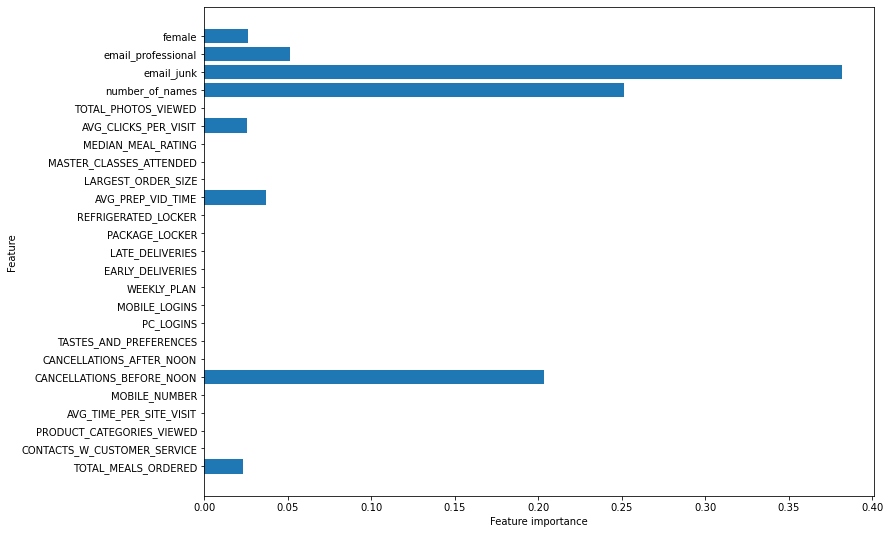

In [38]:
# Plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train  = x_train,
                         export = False)

In [39]:
# Comparing results
print(f"""
Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      {logreg_auc_score}         {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Full Tree     {full_tree_auc_score}         {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree   {pruned_tree_auc_score}         {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
""")


# Creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, pruned_tree_auc_score],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           pruned_tree_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp)]}


# Converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      0.6306         (53, 103, 26, 305)
Full Tree     0.6403         (81, 75, 79, 252)
Pruned Tree   0.696         (72, 84, 23, 308)



# Part V: Hyperparameter Tuning with RandomizedSearchCV

### a) Logistic Regression with Tuned Hyperparameters

In [40]:
"""
########################################
# RandomizedSearchCV
########################################

# Declaring a hyperparameter space
C_space          = pd.np.arange(0.1, 5.0, 0.1)
warm_start_space = [True, False]
solver_space     = ['newton-cg', 'sag', 'lbfgs']


# Creating a hyperparameter grid
param_grid = {'C'          : C_space,
              'warm_start' : warm_start_space,
              'solver'     : solver_space}


# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000)


# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(chef_df_data, chef_df_target)


# PREDICT step is not needed


# Printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))
"""

'\n########################################\n# RandomizedSearchCV\n########################################\n\n# Declaring a hyperparameter space\nC_space          = pd.np.arange(0.1, 5.0, 0.1)\nwarm_start_space = [True, False]\nsolver_space     = [\'newton-cg\', \'sag\', \'lbfgs\']\n\n\n# Creating a hyperparameter grid\nparam_grid = {\'C\'          : C_space,\n              \'warm_start\' : warm_start_space,\n              \'solver\'     : solver_space}\n\n\n# INSTANTIATING the model object without hyperparameters\nlr_tuned = LogisticRegression(random_state = 219,\n                              max_iter     = 1000)\n\n\n# GridSearchCV object\nlr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object\n                                 param_distributions = param_grid, # parameters to tune\n                                 cv                  = 3,          # how many folds in cross-validation\n                                 n_iter              = 250,        

In [41]:
# Checking the best estimator for the model
#lr_tuned_cv.best_estimator_

In [42]:
# Building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
lr_tuned = LogisticRegression(C=0.7000000000000001, max_iter=1000, random_state=219,
                   solver='newton-cg')

# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned.fit(chef_df_data, chef_df_target)

# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_tuned_pred).round(4))


# Saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# Saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

Training ACCURACY: 0.7395
Testing  ACCURACY: 0.7536
AUC Score        : 0.6662


Checking Confusion Matrix

In [43]:
# Unpacking the confusion matrix
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")


True Negatives : 66
False Positives: 90
False Negatives: 30
True Positives : 301



In [44]:
# Declaring model performance objects
lr_train_acc = lr_tuned.score(x_train, y_train).round(4)
lr_test_acc  = lr_tuned.score(x_test, y_test).round(4)
lr_auc       = roc_auc_score(y_true  = y_test,
                             y_score = lr_tuned_pred).round(4)
# Appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned LR',
                           'Training Accuracy' : lr_train_acc,
                           'Testing Accuracy'  : lr_test_acc,
                           'AUC Score'         : lr_auc,
                           'Confusion Matrix'  : (lr_tuned_tn,
                                                  lr_tuned_fp,
                                                  lr_tuned_fn,
                                                  lr_tuned_tp)},
                           ignore_index = True)


# Checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6306,0.7354,0.7351,"(53, 103, 26, 305)"
1,Full Tree,0.6403,1.0000,0.6838,"(81, 75, 79, 252)"
2,Pruned Tree,0.6960,0.7526,0.7803,"(72, 84, 23, 308)"
3,Tuned LR,0.6662,0.7395,0.7536,"(66, 90, 30, 301)"


### b) Logistic Regression with Tuned Hyperparameters

In [45]:
"""
# Declaring a hyperparameter space
criterion_space = ['gini', 'entropy']
splitter_space  = ['best', 'random']
depth_space     = pd.np.arange(1, 25, 1)
leaf_space      = pd.np.arange(1, 100, 1)


# Creating a hyperparameter grid
param_grid = {'criterion'        : criterion_space,
              'splitter'         : splitter_space,
              'max_depth'        : depth_space,
              'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)
# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 1000,
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(chef_df_data, chef_df_target)


# PREDICT step is not needed


# Printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))
"""

'\n# Declaring a hyperparameter space\ncriterion_space = [\'gini\', \'entropy\']\nsplitter_space  = [\'best\', \'random\']\ndepth_space     = pd.np.arange(1, 25, 1)\nleaf_space      = pd.np.arange(1, 100, 1)\n\n\n# Creating a hyperparameter grid\nparam_grid = {\'criterion\'        : criterion_space,\n              \'splitter\'         : splitter_space,\n              \'max_depth\'        : depth_space,\n              \'min_samples_leaf\' : leaf_space}\n\n\n# INSTANTIATING the model object without hyperparameters\ntuned_tree = DecisionTreeClassifier(random_state = 219)\n# RandomizedSearchCV object\ntuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,\n                                   param_distributions   = param_grid,\n                                   cv                    = 3,\n                                   n_iter                = 1000,\n                                   random_state          = 219,\n                                   scoring = make_scorer(

In [46]:
# Checking the best estimator for the model
#tuned_tree_cv.best_estimator_

In [47]:
# Building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
tree_tuned = DecisionTreeClassifier(max_depth=3, min_samples_leaf=16, random_state=219)

# FITTING to the FULL DATASET (due to cross-validation)
tree_tuned.fit(chef_df_data, chef_df_target)

# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))
# Saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# Saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.7402
Testing  ACCURACY: 0.7762
AUC Score        : 0.732


In [48]:
# Unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")


True Negatives : 95
False Positives: 61
False Negatives: 48
True Positives : 283



In [49]:
# Declaring model performance objects
tree_train_acc = tree_tuned.score(x_train, y_train).round(4)
tree_test_acc  = tree_tuned.score(x_test, y_test).round(4)
tree_auc       = roc_auc_score(y_true  = y_test,
                              y_score = tree_tuned_pred).round(4)


# Appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned Tree',
                           'Training Accuracy' : tree_train_acc,
                           'Testing Accuracy'  : tree_test_acc,
                           'AUC Score'         : tree_auc,
                           'Confusion Matrix'  : (tuned_tree_tn,
                                                  tuned_tree_fp,
                                                  tuned_tree_fn,
                                                  tuned_tree_tp)},
                           ignore_index = True)


# Checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6306,0.7354,0.7351,"(53, 103, 26, 305)"
1,Full Tree,0.6403,1.0000,0.6838,"(81, 75, 79, 252)"
2,Pruned Tree,0.6960,0.7526,0.7803,"(72, 84, 23, 308)"
3,Tuned LR,0.6662,0.7395,0.7536,"(66, 90, 30, 301)"
4,Tuned Tree,0.7320,0.7402,0.7762,"(95, 61, 48, 283)"


# Part VI: Random Forest

### a) Building a random forest model

In [50]:
# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

In [51]:
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))


# Saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 1.0
Testing  ACCURACY: 0.77
AUC Score        : 0.6851


<ipython-input-4-0c71b2e3d4a7>:63: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


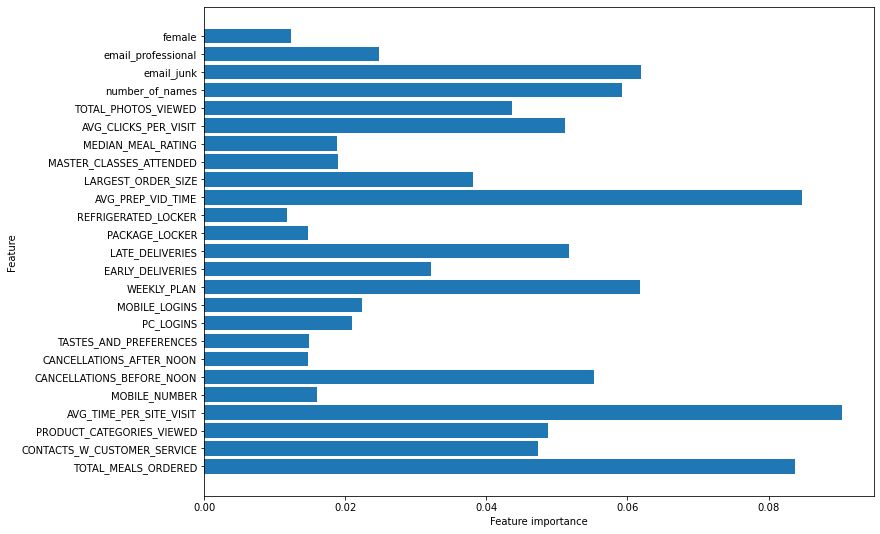

In [52]:
# Plotting feature importances
plot_feature_importances(rf_default_fit,
                         train = x_train,
                         export = False)

In [53]:
# Unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# Printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")


True Negatives : 70
False Positives: 86
False Negatives: 26
True Positives : 305



In [54]:
# Declaring model performance objects
rf_train_acc = rf_default_fit.score(x_train, y_train).round(4)
rf_test_acc  = rf_default_fit.score(x_test, y_test).round(4)
rf_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)


# Appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest (Full)',
                           'Training Accuracy'  : rf_train_acc,
                           'Testing Accuracy'   : rf_test_acc,
                           'AUC Score'          : rf_auc,
                           'Confusion Matrix'   : (rf_tn,
                                                   rf_fp,
                                                   rf_fn,
                                                   rf_tp)},
                          ignore_index = True)


# Checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6306,0.7354,0.7351,"(53, 103, 26, 305)"
1,Full Tree,0.6403,1.0000,0.6838,"(81, 75, 79, 252)"
2,Pruned Tree,0.6960,0.7526,0.7803,"(72, 84, 23, 308)"
3,Tuned LR,0.6662,0.7395,0.7536,"(66, 90, 30, 301)"
4,Tuned Tree,0.7320,0.7402,0.7762,"(95, 61, 48, 283)"
5,Random Forest (Full),0.6851,1.0000,0.7700,"(70, 86, 26, 305)"


### b) Random Forest with Tuned Hyperparameters -- Final Model

In [55]:
"""
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# Declaring a hyperparameter space
estimator_space  = pd.np.arange(100, 1100, 250)
leaf_space       = pd.np.arange(1, 31, 10)
criterion_space  = ['gini', 'entropy']
bootstrap_space  = [True, False]
warm_start_space = [True, False]


# Creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'min_samples_leaf' : leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 3,
                               n_iter     = 1000,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(chef_df_data, chef_df_target)


# PREDICT step is not needed


# Printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))
"""

'\n# FITTING the training data\nrf_default_fit = rf_default.fit(x_train, y_train)\n\n\n# PREDICTING based on the testing set\nrf_default_fit_pred = rf_default_fit.predict(x_test)\n\n\n# Declaring a hyperparameter space\nestimator_space  = pd.np.arange(100, 1100, 250)\nleaf_space       = pd.np.arange(1, 31, 10)\ncriterion_space  = [\'gini\', \'entropy\']\nbootstrap_space  = [True, False]\nwarm_start_space = [True, False]\n\n\n# Creating a hyperparameter grid\nparam_grid = {\'n_estimators\'     : estimator_space,\n              \'min_samples_leaf\' : leaf_space,\n              \'criterion\'        : criterion_space,\n              \'bootstrap\'        : bootstrap_space,\n              \'warm_start\'       : warm_start_space}\n\n\n# INSTANTIATING the model object without hyperparameters\nforest_grid = RandomForestClassifier(random_state = 219)\n\n\n# GridSearchCV object\nforest_cv = RandomizedSearchCV(estimator           = forest_grid,\n                               param_distributions =

In [56]:
# Best estimators based on RandomizedSearchCV
#forest_cv.best_estimator_

In [57]:
# building a model based on hyperparameter tuning results

# copy/pasting in the best_estimator_ results
# to avoid running another RandomizedSearch
forest_tuned = RandomForestClassifier(bootstrap=False, min_samples_leaf=11, random_state=219,
                       warm_start=True)


# FITTING the model object
forest_tuned_fit = forest_tuned.fit(chef_df_data, chef_df_target)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

Forest Tuned Training ACCURACY: 0.83
Forest Tuned Testing  ACCURACY: 0.8501
Forest Tuned AUC Score        : 0.7813


<ipython-input-4-0c71b2e3d4a7>:63: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


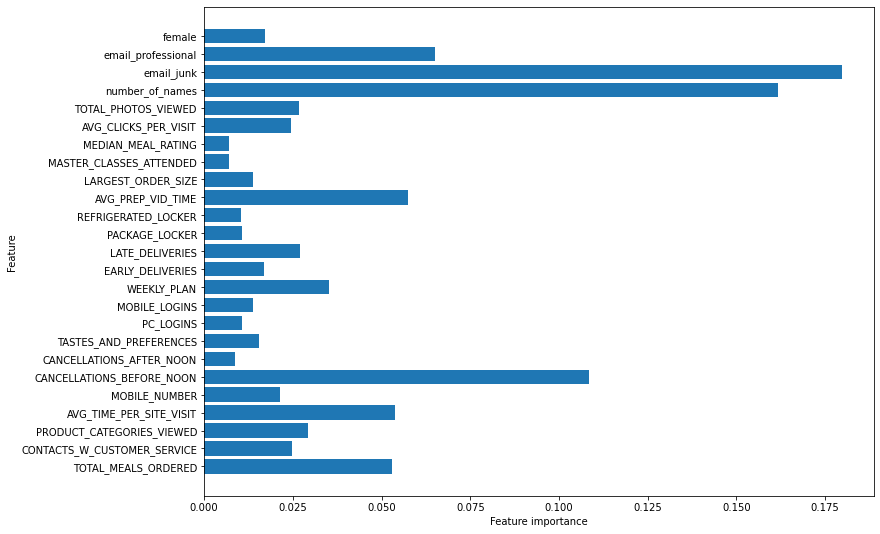

In [58]:
# plotting feature importances
plot_feature_importances(forest_tuned_fit,
                         train = x_train,
                         export = False)

In [59]:
# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")


True Negatives : 92
False Positives: 64
False Negatives: 9
True Positives : 322



In [60]:
# declaring model performance objects
tuned_rf_train_acc = forest_tuned_fit.score(x_train, y_train).round(4)
tuned_rf_test_acc  = forest_tuned_fit.score(x_test, y_test).round(4)
tuned_rf_auc       = roc_auc_score(y_true  = y_test,
                                   y_score = forest_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Tuned Random Forest (Full)',
                           'Training Accuracy'  : tuned_rf_train_acc,
                           'Testing Accuracy'   : tuned_rf_test_acc,
                           'AUC Score'          : tuned_rf_auc,
                           'Confusion Matrix'   : (tuned_rf_tn,
                                                   tuned_rf_fp,
                                                   tuned_rf_fn,
                                                   tuned_rf_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6306,0.7354,0.7351,"(53, 103, 26, 305)"
1,Full Tree,0.6403,1.0000,0.6838,"(81, 75, 79, 252)"
2,Pruned Tree,0.6960,0.7526,0.7803,"(72, 84, 23, 308)"
3,Tuned LR,0.6662,0.7395,0.7536,"(66, 90, 30, 301)"
4,Tuned Tree,0.7320,0.7402,0.7762,"(95, 61, 48, 283)"
5,Random Forest (Full),0.6851,1.0000,0.7700,"(70, 86, 26, 305)"
6,Tuned Random Forest (Full),0.7813,0.8300,0.8501,"(92, 64, 9, 322)"


# Final Model : Tuned Random Forest (Full)